In [31]:
import pandas as pd
import numpy as np

import os, sys
np.random.seed(42)

from keras.models import Model
from keras.layers.core import Dense, Activation,Reshape
from keras.layers import Input, concatenate
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

## Funções de apoio ao treinamento

In [29]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  shuffle=True,
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval),
                      shuffle=shuffle,
                      callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Leitura dos arquivos csv e salvando em pickle

- [Cheng Guo, Felix Berkhahn, Entity Embeddings of Categorical Variables, arxiv 2016](https://arxiv.org/abs/1604.06737)
- Kaggle: https://www.kaggle.com/c/rossmann-store-sales/data
    

In [16]:
datapath = '../../datasets/'
train_data_file = datapath + "rossmann_train.csv"
store_states_file = datapath + 'rossmann_store_states.csv'

In [17]:
train_csv = pd.read_csv(train_data_file)
train_csv.head()

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [18]:
states_csv = pd.read_csv(store_states_file).set_index(['Store'])
store_states = states_csv.as_matrix()
states_csv.head()

,State
Store,
1,HE
2,TH
3,NW
4,BE
5,SN


## Preparando as features

In [19]:
train_csv_array = train_csv.as_matrix()
print(train_csv_array.shape)
print(train_csv_array[:5])
open_i = (train_csv_array[:,5]==1) & (train_csv_array[:,3] > 0)

train_open = train_csv_array[open_i]
n_samples = train_open.shape[0]
print(n_samples)
dt = np.array(train_open[:,2].astype('datetime64[D]'))
day = dt - dt.astype('datetime64[M]')
month = dt.astype('datetime64[M]').astype(np.int) % 12
year = dt.astype('datetime64[Y]').astype(int) + 1970

train_Xnew = np.empty((n_samples,7),dtype=np.int)
store_index = train_csv_array[open_i,0].astype(np.int) # store_index
train_Xnew[:,0] = store_index
train_Xnew[:,1] = train_csv_array[open_i,1] # day_of_week
train_Xnew[:,2] = train_csv_array[open_i,6] # promo
train_Xnew[:,3] = year # year
train_Xnew[:,4] = month # month
train_Xnew[:,5] = day # day
for i in np.arange(n_samples):
    train_Xnew[i,6] = id(sys.intern(store_states[store_index[i] - 1,0])) # coloca string do Estado com número único

train_data_y = train_csv_array[open_i,3].astype(np.int) # Sales

print(train_Xnew.min(axis=0))
print(train_Xnew.max(axis=0))

(1017209, 9)
[[1 5 '2015-07-31' 5263 555 1 1 '0' 1]
 [2 5 '2015-07-31' 6064 625 1 1 '0' 1]
 [3 5 '2015-07-31' 8314 821 1 1 '0' 1]
 [4 5 '2015-07-31' 13995 1498 1 1 '0' 1]
 [5 5 '2015-07-31' 4822 559 1 1 '0' 1]]
844338
[         1          1          0       2013          0          0
 4364656512]
[      1115          7          1       2015         11         30
 4675812240]


### Normalização dos atributos categóricos

In [20]:
X_norm = np.empty_like(train_Xnew)
for i in range(X_norm.shape[1]): # para cada coluna (atributo)
    classes, i_norm = np.unique(train_Xnew[:,i], return_inverse=True)
    X_norm[:,i] = i_norm

In [21]:
print(X_norm.min(axis=0))
print(X_norm.max(axis=0))

[0 0 0 0 0 0 0]
[1114    6    1    2   11   30   11]


In [22]:
train_data_X = X_norm
train_data_y = np.array(train_data_y)
print(train_data_X.min(axis=0))
print(train_data_X.max(axis=0))

[0 0 0 0 0 0 0]
[1114    6    1    2   11   30   11]


## Modelo

## Carregando os dados

In [23]:
(X, y) = (train_data_X, train_data_y)



## Normalizando os valores de vendas

$$ Sales_n = \frac{\log{(Sales)}}{Max(\log(Sales))} $$
$$ Sales = \exp(Sales_n Max(\log(Sales))) $$

In [24]:
class log_norm():
    def __init__(self,y):
        self.MaxLog = np.log(y).max()
        
    def lognorm(self, val):
        return np.log(val)/self.MaxLog
    
    def lognorm_back(self, val):
        return np.exp(val * self.MaxLog)

classnorm = log_norm(y)
y_norm = classnorm.lognorm(y)
y_back = classnorm.lognorm_back(y_norm)


## Dividindo em Dados de treinamento e de validação

In [25]:
num_records = len(X)
train_ratio = 0.9
train_size = int(train_ratio * num_records)

X_train = X[:train_size]
X_val   = X[train_size:]
y_train = y_norm[:train_size]
y_val   = y_norm[train_size:]
print('Shapes:',X_train.shape,y_train.shape,X_val.shape,y_val.shape)
print('X_train[:2]\n',X_train[:2])
print('y_train[:2]\n',y_train[:2])

Shapes: (759904, 7) (759904,) (84434, 7) (84434,)
X_train[:2]
 [[ 0  4  1  2  6 30  0]
 [ 1  4  1  2  6 30  1]]
y_train[:2]
 [ 0.80570915  0.81903052]


In [26]:
def sample(X, y, n):
    '''random samples'''
    num_row = X.shape[0]
    indices = np.random.randint(num_row, size=n)
    return X[indices, :], y[indices]

X_train, y_train = sample(X_train, y_train, 200000)  # Simulate data sparsity
print("Number of samples used for training: ",y_train.shape[0])

Number of samples used for training:  200000


## Criando o modelo

### Modelo com vários embeddings


|Característica|tipo do dado|tamanho|dimensão embedding|
|--------------|------------|-------|------------------|
| store      | nominal| 1115|10|
| day of week| ordinal| 7| 6|
|promoção| binário | 2|1|
| ano| ordinal| 3 (2013-2015)|2|
| mês| ordinal| 12| 6|
| dia| ordinal| 31| 10|
| Estado|nominal| 12| 6|
 


In [27]:
def build_keras_model():
    store_in = Input(shape=(1,), dtype='int64', name='store_in')
    x = Embedding(1115, 10, input_length=1, name='store_embedding')(store_in)
    store_emb = Reshape(target_shape=(10,), name='store_reshape')(x)

    dow_in = Input(shape=(1,), dtype='int64', name='down_in')
    x = Embedding(7, 6, input_length=1, name='dow_embedding')(dow_in)
    dow_emb = Reshape(target_shape=(6,), name='dow_reshape')(x)

    promo_in = Input(shape=(1,), name='promo_in')
    promo_out = Dense(1, input_dim=1)(promo_in)

    year_in = Input(shape=(1,), dtype='int64', name='year_in')
    x = Embedding(3, 2, input_length=1, name='year_embedding')(year_in)
    year_emb = Reshape(target_shape=(2,))(x)

    month_in = Input(shape=(1,), dtype='int64', name='month_in')
    x = Embedding(12, 6, input_length=1, name='month_embedding')(month_in)
    month_emb = Reshape(target_shape=(6,))(x)

    day_in = Input(shape=(1,), dtype='int64', name='day_in')
    x = Embedding(31, 10, input_length=1, name='day_embedding')(day_in)
    day_emb = Reshape(target_shape=(10,))(x)

    germanstate_in = Input(shape=(1,), dtype='int64', name='germanstate_in')
    x = Embedding(12, 6, input_length=1, name='germanstate_embedding')(germanstate_in)
    germanstate_emb = Reshape(target_shape=(6,))(x)

    xin = concatenate([store_emb, dow_emb, promo_out, year_emb, month_emb, day_emb, germanstate_emb])
    x = Dense(1000, kernel_initializer='uniform', activation='relu')(xin)
    x = Dense(500, kernel_initializer='uniform', activation='relu')(x)
    x_out = Dense(1, activation='sigmoid')(x)
    
    return Model([store_in,dow_in,promo_in,year_in,month_in,day_in,germanstate_in], x_out)

model_rs = build_keras_model()
print(model_rs.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
store_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
down_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
year_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
month_in (InputLayer)            (None, 1)             0                                            
___________________________________________________________________________________________

### Treinando

In [28]:
def split_features(X):
    store_index = X[..., [0]]
    day_of_week = X[..., [1]]
    promo = X[..., [2]]
    year = X[..., [3]]
    month = X[..., [4]]
    day = X[..., [5]]
    State = X[..., [6]]
    return [store_index,day_of_week,promo,year,month,day,State]
 
X_train_p = split_features(X_train)
X_val_p = split_features(X_val)
print(X_train.shape, X_val.shape)
print('Número de promoções (sem promoção, com promoção):',np.bincount(X_train[:,3]))

(200000, 7) (84434, 7)
Número de promoções (sem promoção, com promoção): [66745 81655 51600]


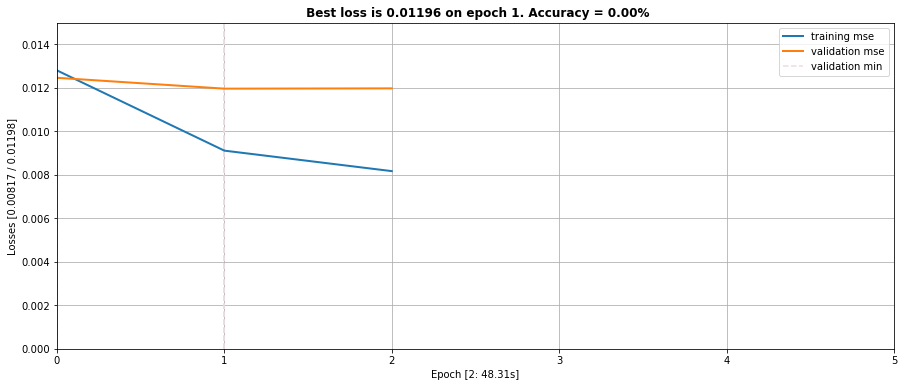

In [33]:
model_name = '../../models/rossmann'
fit_params = {
    'model_name': model_name,
    'loss': 'mean_absolute_error',
    'opt':        Adam(), 
    'batch_size': 128, 
    'nepochs':    5,
    'patience':   15,
    'ploss':      0.015,
    'shuffle':    False,
    'reset':      False,
}

train_network(model_rs, X_train_p, y_train, X_val_p, y_val, **fit_params);

## Avaliando o modelo

In [34]:
def guess(model,features):
    features = split_features(features)
    result = model.predict(features).flatten()
    return result

In [35]:
def evaluate_model(model, X, y):
    assert(min(y) > 0)
    guessed_sales = np.array([guess(model,X)])
    mean_sales = guessed_sales.mean(axis=0)
    mean_sales_back = classnorm.lognorm_back(mean_sales)
    y_back = classnorm.lognorm_back(y)
    relative_err = np.absolute((y_back - mean_sales_back) / y_back)
    result = np.sum(relative_err) / len(y_back)
    return result

model_rs, histo = load_model_and_history(model_name)

print("Evaluate combined models...")
print("Training error...")
r_train = evaluate_model(model_rs, X_train, y_train)
print(r_train)

print("Validation error...")
r_val = evaluate_model(model_rs, X_val, y_val)
print(r_val)

Evaluate combined models...
Training error...
0.0800144725026
Validation error...
0.135739905436


Vencedor da competição no Kaggle obteve 0.10021 [https://www.kaggle.com/c/rossmann-store-sales/leaderboard](https://www.kaggle.com/c/rossmann-store-sales/leaderboard)